# Semantic Segmentation

## Introduction
Semantic Segmentation has gained a lot of popularity in the recent times in the field of computer vision and deep learning because of its variety of application in aerial imagery and autonomous car driving to segment the different parts of field of view so that a car can identify each object and different sections of the road. In aerial imagery, semantic segmentation can be used to locate a plain field so that a flight can be landed in a safe zone of an emergency.

## Objective
The aim of this project is to segment different objects, landforms, buildings, animals, car and water-body, etc. in different colors. here we have 24 different labels mentioned below: <br>
1	paved-area <br>
2	dirt <br>
3	grass	<br>
4	gravel	<br>
5	water	<br>
6	rocks	<br>
7	pool	<br>
8	vegetation	<br>
9	roof	<br>
10	wall	<br>
11	window	<br>
12	door	<br>
13	fence	<br>
14	fence-pole	<br>
15	person	<br>
16	dog	<br>
17	car <br>
18	bicycle	<br>
19	tree	<br>
20	bald-tree	<br>
21	ar-marker	<br>
22	obstacle	<br>
23	conflicting	<br>
24 Unlabeled <br>

We have around 400 images and each image has a dimension 6000x4000 which is in very high quality. We are taking two different approaches to see which one will perform better:
1. As the images are of very large size we will resize them to lower dimensions to increase the training speed. 
2. We will divide the original 6000x4000 images into smaller 1000x1000 patch sizes, which will give us more training data.

https://www.tugraz.at/index.php?id=22387 - Dataset

In [8]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

## 1. By Resizing the images to smaller dimensions

In [9]:
sm.set_framework('tf.keras')

### 1.1 Data Loading and manipulation

In [10]:
# loading image data...
def data_loader(folder_dir):
    # folder_dir = "../data/semantic_drone_dataset/training_set/images/"
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [11]:
image_dataset = data_loader("../data/semantic_drone_dataset/training_set/images/") # real images...

In [12]:
mask_dataset = data_loader("../data/semantic_drone_dataset/training_set/gt/semantic/label_images/") # masked images...

In [13]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [14]:
mask_dataset.shape

(400, 128, 128, 3)

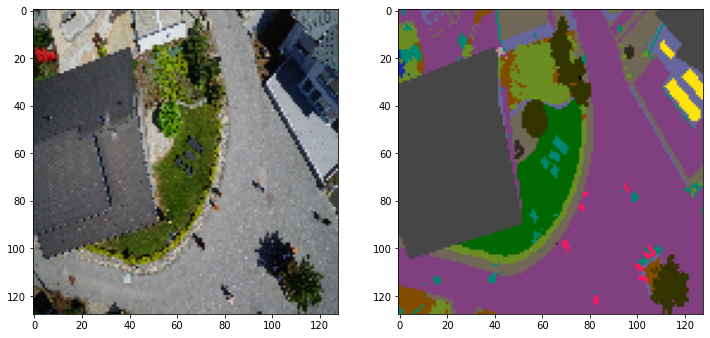

In [15]:
# Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [16]:
mask_labels = pd.read_csv('../data/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv') # mask labels RGB values...

In [17]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [18]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [19]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [20]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dim...

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


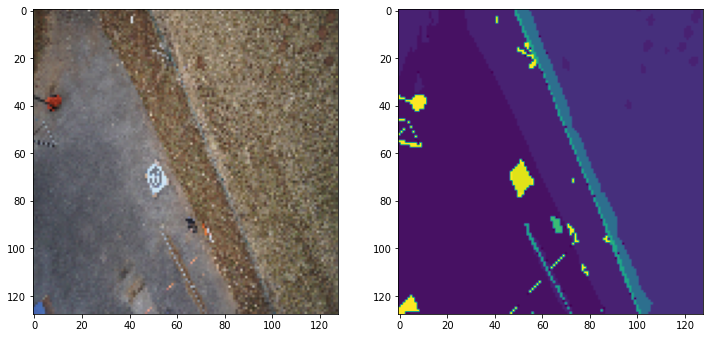

In [21]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [22]:
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...

In [23]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

### 1.2 Modelling

We are using resnet pre-trained model to set the initial weights of the UNet. Below is the architecture of the Resnet34: </br>

![Resnet34](../plots/Resnet34.png) 

In [24]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [25]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

We are using UNet architecture to train our model for semantic segmentation, below is the architecture of UNet: <br>

![UNet](../plots/UNet.png)



In [24]:
# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [25]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [26]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [27]:
# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
20/20 [==============================] - 19s 149ms/step - loss: 2.6234 - accuracy: 0.3005 - val_loss: 337.0873 - val_accuracy: 0.3743
Epoch 2/100
20/20 [==============================] - 2s 91ms/step - loss: 1.7118 - accuracy: 0.5557 - val_loss: 1746.0358 - val_accuracy: 0.3769
Epoch 3/100
20/20 [==============================] - 2s 85ms/step - loss: 1.4643 - accuracy: 0.5925 - val_loss: 8859.4678 - val_accuracy: 0.2291
Epoch 4/100
20/20 [==============================] - 2s 84ms/step - loss: 1.3476 - accuracy: 0.6230 - val_loss: 2177.6528 - val_accuracy: 0.2544
Epoch 5/100
20/20 [==============================] - 2s 81ms/step - loss: 1.2619 - accuracy: 0.6443 - val_loss: 55.7210 - val_accuracy: 0.3759
Epoch 6/100
20/20 [==============================] - 2s 80ms/step - loss: 1.2030 - accuracy: 0.6553 - val_loss: 78.4555 - val_accuracy: 0.4236
Epoch 7/100
20/20 [==============================] - 2s 86ms/step - loss: 1.1760 - accuracy: 0.6567 - val_loss: 46.9147 - val_accurac

### 1.3 Results

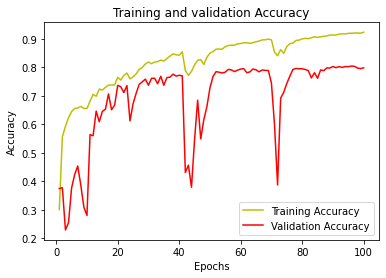

In [28]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
# model_resnet_backbone.save('../models/resnet_backbone.hdf5')

In [26]:
model = load_model('../models/resnet_backbone.hdf5') # loading model...

In [27]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [28]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

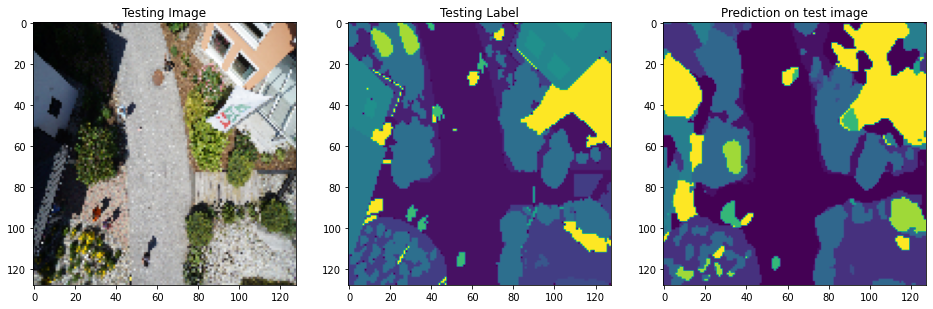

In [29]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

## 2. By Patchifying the Images into smaller images

### 2.1 Data Loading and Manipulation

In [2]:
patch_size = 1000

In [3]:
def patched_data_load(folder_dir, patch_size):
    image_dataset = []
    # scaler = MinMaxScaler()
    random.seed(a=42)
    for images in tqdm(random.sample(os.listdir(folder_dir), 100)):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
        # SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
        # image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        # image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        image = np.array(image)
        # print("Now patchifying image:", folder_dir+"/"+images)
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                #Use minmaxscaler instead of just dividing by 255. 
                # single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.   
                single_patch_img = cv2.resize(single_patch_img, (128, 128))
                image_dataset.append(single_patch_img)
    return image_dataset

In [4]:
patched_image_dataset = patched_data_load("../data/semantic_drone_dataset/training_set/images", patch_size)

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


In [5]:
patched_mask_dataset = patched_data_load("../data/semantic_drone_dataset/training_set/gt/semantic/label_images/", patch_size)

100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


In [6]:
patched_image_dataset = np.array(patched_image_dataset)

In [7]:
patched_mask_dataset = np.array(patched_mask_dataset)

In [8]:
patched_image_dataset.shape

(2400, 128, 128, 3)

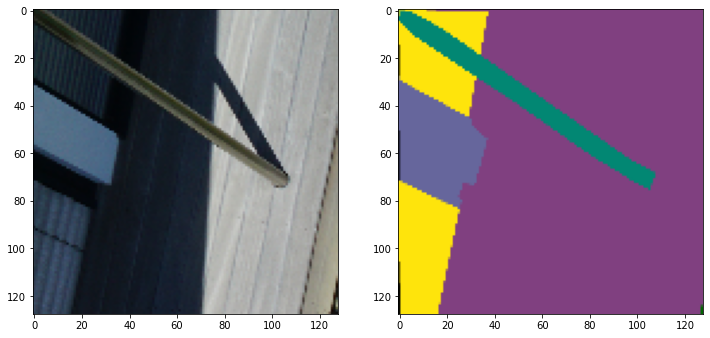

In [9]:
image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_mask_dataset[image_number])
plt.show()

In [10]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    return label_seg

In [13]:
patched_labels = []
for i in tqdm(range(patched_mask_dataset.shape[0])):
    patched_label = rgb_to_labels(patched_mask_dataset[i], mask_labels)
    patched_labels.append(patched_label)

100%|██████████| 2400/2400 [00:27<00:00, 86.32it/s]


In [14]:
patched_labels = np.array(patched_labels)
patched_labels = np.expand_dims(patched_labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


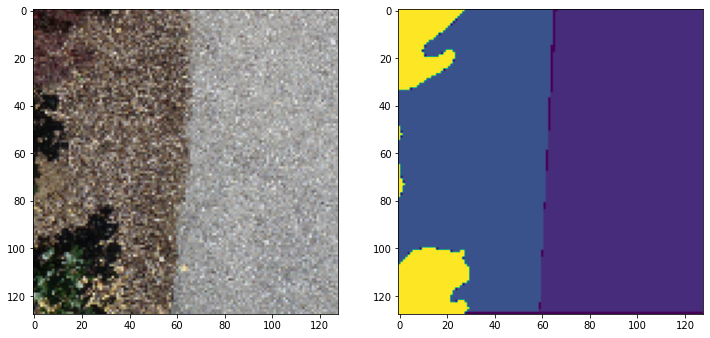

In [15]:
print("Unique labels in label dataset are: ", np.unique(patched_labels))

image_number = random.randint(0, len(patched_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(patched_image_dataset[image_number])
plt.subplot(122)
plt.imshow(patched_labels[image_number][:,:,0])
plt.show()

In [16]:
n_classes = len(np.unique(patched_labels))
patched_labels_cat = to_categorical(patched_labels, num_classes=n_classes)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(patched_image_dataset, patched_labels_cat, test_size = 0.20, random_state = 42)

### 2.2 Modeling

In [18]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [19]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [22]:
# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [ ]:
tf.keras.backend.clear_session() # Removes the values in the graph(network connections) but do not delete the graph itself... helps in RAM cleaning...

In [45]:
metrics=['accuracy']
opt = Adam(learning_rate = 0.002) # Adam optimizer with learning rate 0.001...
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [44]:
# ModelCheckpoint callback is used to save only the best model out of all the epochs...
checkpoint = ModelCheckpoint(filepath="../models/patched_resnet_backbone.h5", verbose=2, save_best_only=True)

# EarlyStopping callback is used to stop the training when accuracy doesn't improve for 5 epochs...
early_stop = EarlyStopping(monitor="accuracy", min_delta=0, patience=5)

callbacks = [checkpoint, early_stop]

In [ ]:
# training the model for 100 epochs with batch size of 16...
history1 = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=32, 
          epochs=100,
          callbacks=callbacks,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

### 2.3 Results

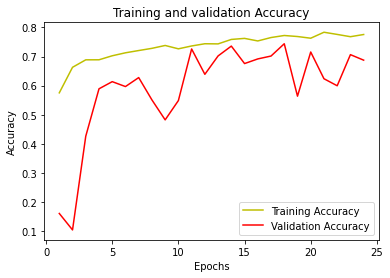

In [26]:
# plotting train and val accuracy in each epoch...
history = history1
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
patched_model = load_model('../models/patched_resnet_backbone.h5') # loading model...

In [31]:
# making predictions...
y_pred=patched_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

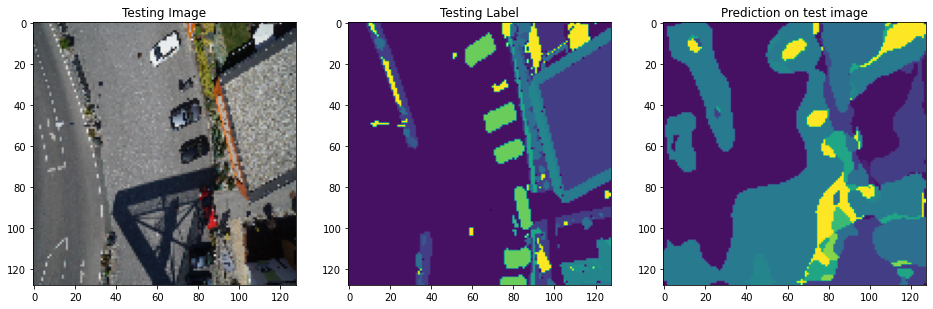

In [42]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (patched_model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

## Conclusion
1st approach seems to be better which is by resizing the images to lower dimensions. Initially, the assumption was the 2nd approach will perform better as it will have more training data, however, in the end, that was not the case. This could be mainly because, while patching some of the objects will be divided into different images and those images might have fallen into different batches. 

## Future Scope
- Investigate further how the accuracy of 2nd approach can be improved. Maybe by dividing the test train data on some specific parameter rather than randomly. 
- Resnet was used as the backbone for our UNet, there are many other state of the art pre-trained models in the market. They can also be tried to see whether there is any performance gain.